# Improving the Features

Contents
1. [Distribution of the Labelled Classes over the Coordinates](#s2)
2. [Coordinate and Colour Features](#s3)
3. [Reddening Correction](#s4)

In [6]:
import numpy as np
import pandas as pd
import pickle
import ephem
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas import MultiIndex
from IPython.display import display
from IPython.core.display import HTML
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LogNorm
from sklearn import metrics
from mclearn import *

%matplotlib inline
plt.style.use('ggplot')


# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# stylesheet for notebook
HTML(open("styles/stylesheet.css", "r").read())

# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip")

## 1. Distribution of the Labelled Classes over the Coordinates <a id='s2'></a>

We have around 2.8 million labelled data points. Below are the maps showing how the three classes - galaxies, stars, and quasars - are distributed.

In [99]:
galaxy_ra, galaxy_dec = sdss[sdss['class']=='Galaxy']['ra'], sdss[sdss['class']=='Galaxy']['dec']
star_ra, star_dec = sdss[sdss['class']=='Star']['ra'], sdss[sdss['class']=='Star']['dec']
quasar_ra, quasar_dec = sdss[sdss['class']=='Quasar']['ra'], sdss[sdss['class']=='Quasar']['dec']

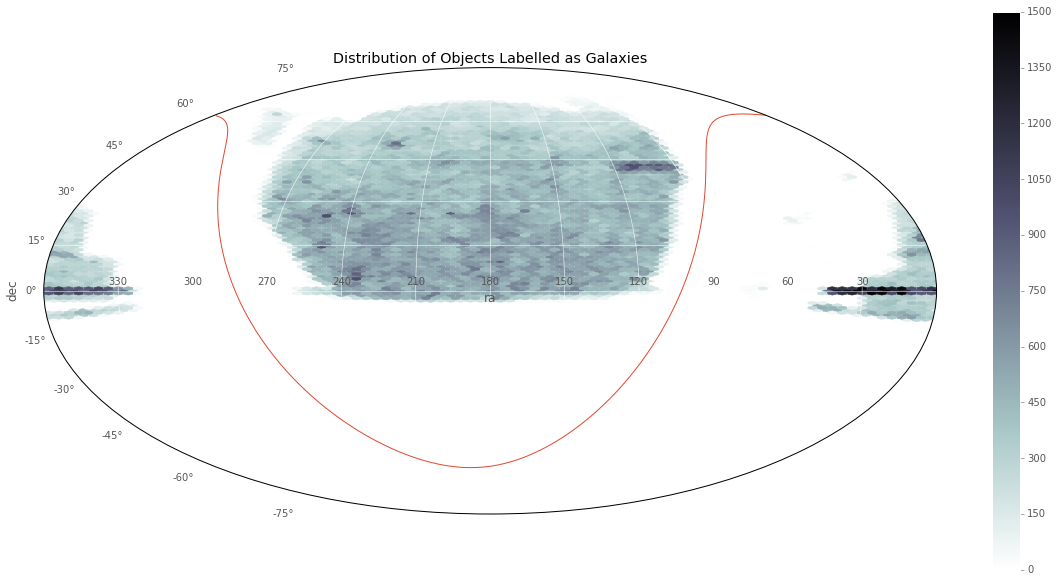

In [100]:
plot_hex_map(galaxy_ra, galaxy_dec, origin=180, title='Distribution of Objects Labelled as Galaxies', milky_way=True)

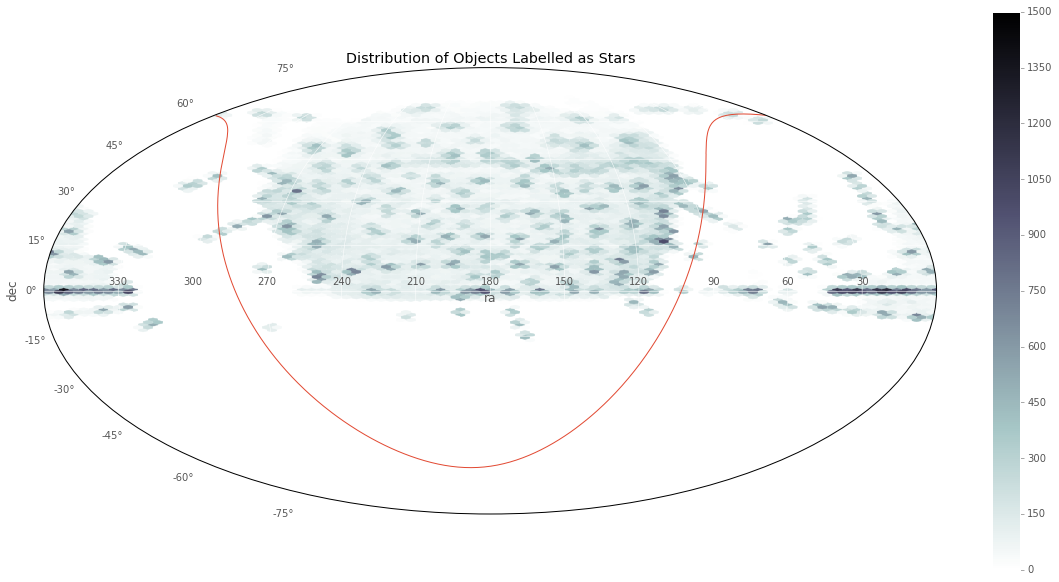

In [101]:
plot_hex_map(star_ra, star_dec, origin=180, title='Distribution of Objects Labelled as Stars', milky_way=True)

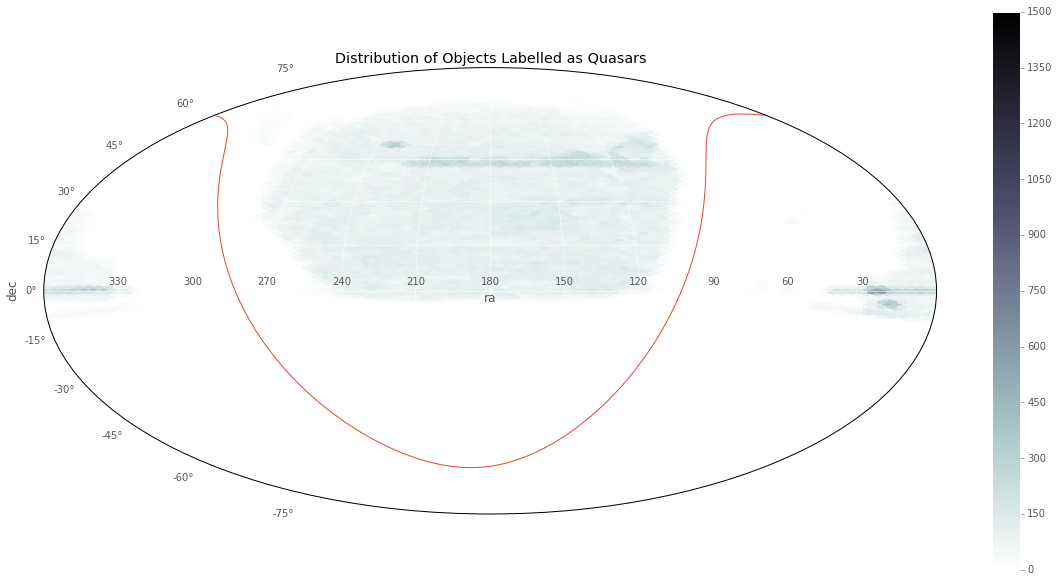

In [102]:
plot_hex_map(quasar_ra, quasar_dec, origin=180, title='Distribution of Objects Labelled as Quasars', milky_way=True)

We can also just look at a small region in the sky. We can see that the distribution is quite uniform.

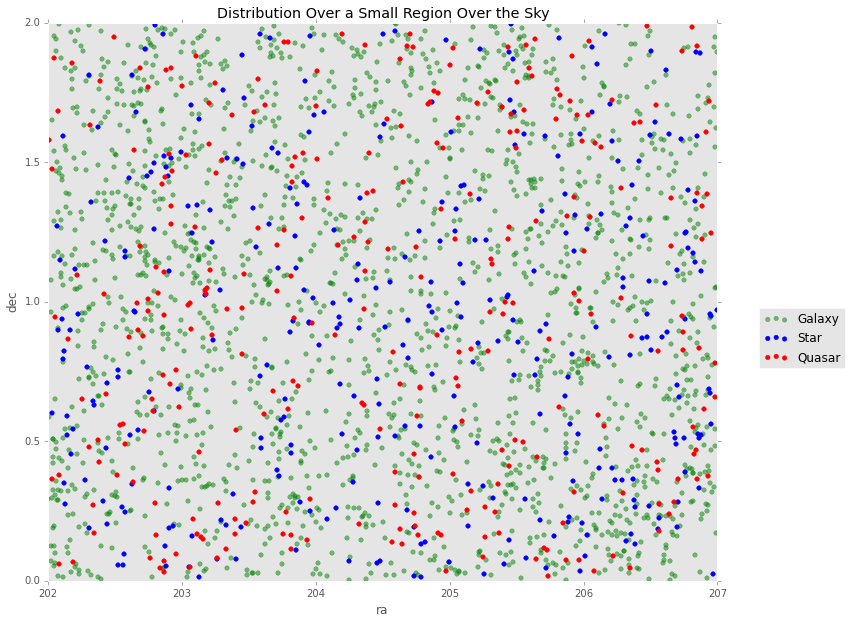

In [36]:
ra_small = np.logical_and(sdss['ra'] < 207, sdss['ra'] > 202)
dec_small = np.logical_and(sdss['dec'] > 0, sdss['dec'] < 2)
ra_dec_small = np.logical_and(ra_small, dec_small)
sdss_small = sdss[ra_dec_small]

galaxy_small_ra = sdss_small[sdss_small['class']=='Galaxy']['ra']
galaxy_small_dec = sdss_small[sdss_small['class']=='Galaxy']['dec']
star_small_ra = sdss_small[sdss_small['class']=='Star']['ra']
star_small_dec = sdss_small[sdss_small['class']=='Star']['dec']
quasar_small_ra = sdss_small[sdss_small['class']=='Quasar']['ra']
quasar_small_dec = sdss_small[sdss_small['class']=='Quasar']['dec']

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(galaxy_small_ra, galaxy_small_dec, color='green', alpha=0.5 , label='Galaxy')
ax.scatter(star_small_ra, star_small_dec, color='blue', label='Star')
ax.scatter(quasar_small_ra, quasar_small_dec, color='red', label='Quasar')

ax.legend(bbox_to_anchor=(1.2, 0.5))
ax.set_title('Distribution Over a Small Region Over the Sky')
ax.grid(False)
ax.set_xlim(202, 207)
ax.set_ylim(0, 2)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
plt.show()

Here the points look quite randomly distributed. Hidden in there, however, is a very spetial type of quasar

## 2. Coordinate and Colour Features <a id='s3'></a>

Let us add a routine to train a random forest.

In [3]:
def train_random_forest(sdss, feature_names, drop_coords=True, recall_maps=True):
    """ Train a random forest given a set of features. """
    
    # split the data into a training set
    X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss['class'],
        train_size=0.5, test_size=0.5, random_state=4)

    coords_train = X_train[['ra', 'dec']]
    coords_test = X_test[['ra', 'dec']]
    
    # remove coordinates as features
    if drop_coords:
        X_train.drop(['ra', 'dec'], axis=1, inplace=True)
        X_test.drop(['ra', 'dec'], axis=1, inplace=True)

    # train and test random forest
    clf_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight='auto', random_state=5)
    clf_forest.fit(X_train, y_train)
    y_pred_test = clf_forest.predict(X_test)
    confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
    balanced_accuray_forest = balanced_accuracy_expected(confusion_test)

    # put confusion matrix in a DataFrame
    classes = ['Galaxies', 'Quasars', 'Stars']
    pred_index = MultiIndex.from_tuples(list(zip(['Predicted'] * 3, classes)))
    act_index = MultiIndex.from_tuples(list(zip(['Actual'] * 3, classes)))
    confusion_features_df = DataFrame(confusion_test, columns=pred_index, index=act_index)

    # display results
    print('Here\'s the confusion matrix:')
    display(confusion_features_df)
    print('The balanced accuracy rate is {:.2%}.'.format(balanced_accuray_forest))
    
    # plot the recall maps
    if recall_maps:
        is_galaxy = y_test == 'Galaxy'
        is_star = y_test == 'Star'
        is_quasar = y_test == 'Quasar'
        correct_all = y_test == y_pred_test
        C_func = lambda c: np.sum(c) / len(c) if c else 0
        
        plot_hex_map(coords_test['ra'][is_galaxy], coords_test['dec'][is_galaxy],
             C=correct_all[is_galaxy], reduce_C_function=C_func, origin=180,
             vmin=0.7, vmax=1, mincnt=None, milky_way=True, cmap=plt.cm.YlGn,
             title='Recall on Galaxy')
        
        plot_hex_map(coords_test['ra'][is_star], coords_test['dec'][is_star],
             C=correct_all[is_star], reduce_C_function=C_func, origin=180,
             vmin=0.7, vmax=1, mincnt=None, milky_way=True, cmap=plt.cm.YlGn,
             title='Recall on Stars')
        
        plot_hex_map(coords_test['ra'][is_quasar], coords_test['dec'][is_quasar],
             C=correct_all[is_quasar], reduce_C_function=C_func, origin=180,
             vmin=0.7, vmax=1, mincnt=None, milky_way=True, cmap=plt.cm.YlGn,
             title='Recall on Quasars')
        
    return coords_test, y_test, y_pred_test

### 3.1. Coordinates as Features <a id='s3.1'></a>

Let's train the random forest, now with ra and dec coordinates as two extra features.

In [87]:
feature_names = ["ra", "dec", "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
train_random_forest(sdss, feature_names, drop_coords=False, recall_maps=False);

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     843417     7252    3163
       Quasars        8833   164151   16292
       Stars          6833    21020  329540

The balanced accuracy rate is 92.58%.


### 3.2. Colour Indices Plus One Magnitude <a id='s3.2'></a>

Let's try out a few different combinations of colour indices and magnitudes.

In [17]:
sdss['psf_u_g'] = sdss['psfMag_u'] - sdss['psfMag_g']
sdss['psf_g_r'] = sdss['psfMag_g'] - sdss['psfMag_r']
sdss['psf_r_i'] = sdss['psfMag_r'] - sdss['psfMag_i']
sdss['psf_i_z'] = sdss['psfMag_i'] - sdss['psfMag_z']

sdss['petro_u_g'] = sdss['petroMag_u'] - sdss['petroMag_g']
sdss['petro_g_r'] = sdss['petroMag_g'] - sdss['petroMag_r']
sdss['petro_r_i'] = sdss['petroMag_r'] - sdss['petroMag_i']
sdss['petro_i_z'] = sdss['petroMag_i'] - sdss['petroMag_z']

In [89]:
colour_features = ['ra', 'dec',
                   'psfMag_u', 'petroMag_u', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z']

train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False);

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     842167     7506    4159
       Quasars        9419   164604   15253
       Stars          9699    20781  326913

The balanced accuracy rate is 92.35%.


In [90]:
colour_features = ['ra', 'dec',
                   'psfMag_g', 'petroMag_g', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z']

train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False);

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     842814     7392    3626
       Quasars        9201   164635   15440
       Stars          8486    20069  328838

The balanced accuracy rate is 92.56%.


In [91]:
colour_features = ['ra', 'dec',
                   'psfMag_r', 'petroMag_r', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z']

train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False)

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     843149     7331    3352
       Quasars        9167   164643   15466
       Stars          8292    20187  328914

The balanced accuracy rate is 92.58%.


In [93]:
colour_features = ['ra', 'dec',
                   'psfMag_z', 'petroMag_z', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z']

train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False);

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     842598     7544    3690
       Quasars        9385   164353   15538
       Stars          7669    20438  329286

The balanced accuracy rate is 92.55%.


Here's the confusion matrix:


Predicted                
                 Galaxies Quasars   Stars
Actual Galaxies    843066    7417    3349
       Quasars       9176  164761   15339
       Stars         7599   20350  329444

The balanced accuracy rate is 92.64%.


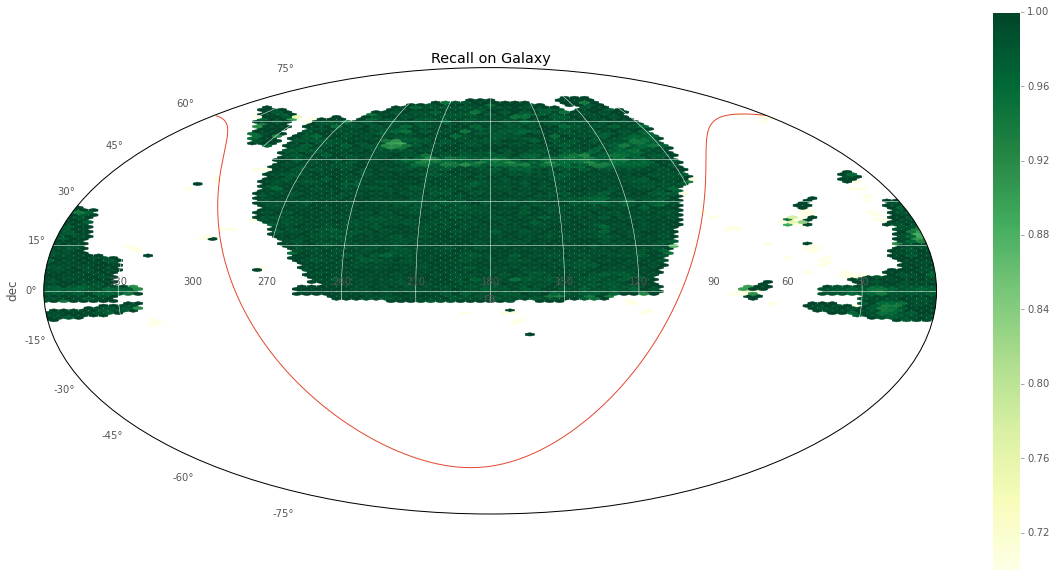

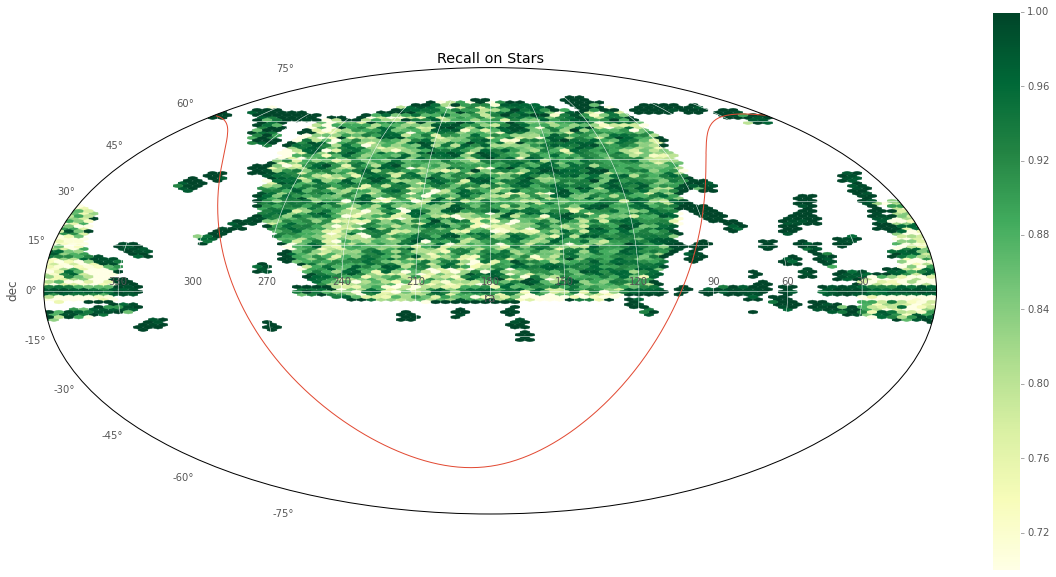

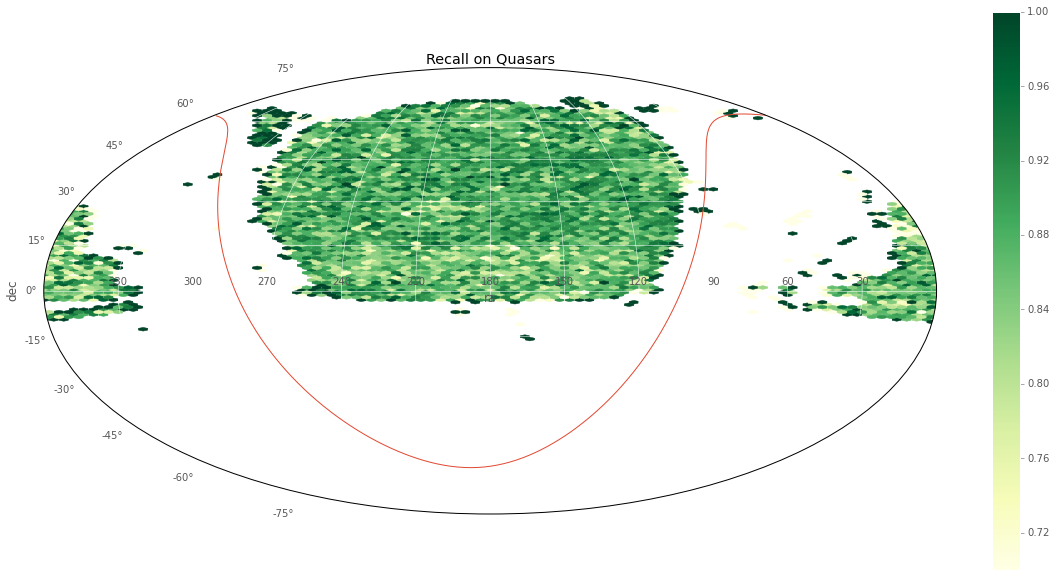

In [18]:
colour_features = ['ra', 'dec',
                   'psfMag_i', 'petroMag_i', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z']

coords_test, y_test, y_pred_test = train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=True)

Some useful variables for the next section.

In [19]:
is_galaxy = y_test == 'Galaxy'
is_star = y_test == 'Star'
is_quasar = y_test == 'Quasar'
correct = y_test == y_pred_test
C_func = lambda c: np.sum(c) / len(c) if c else 0

## 4. Reddening Correction <a id='s4'></a>

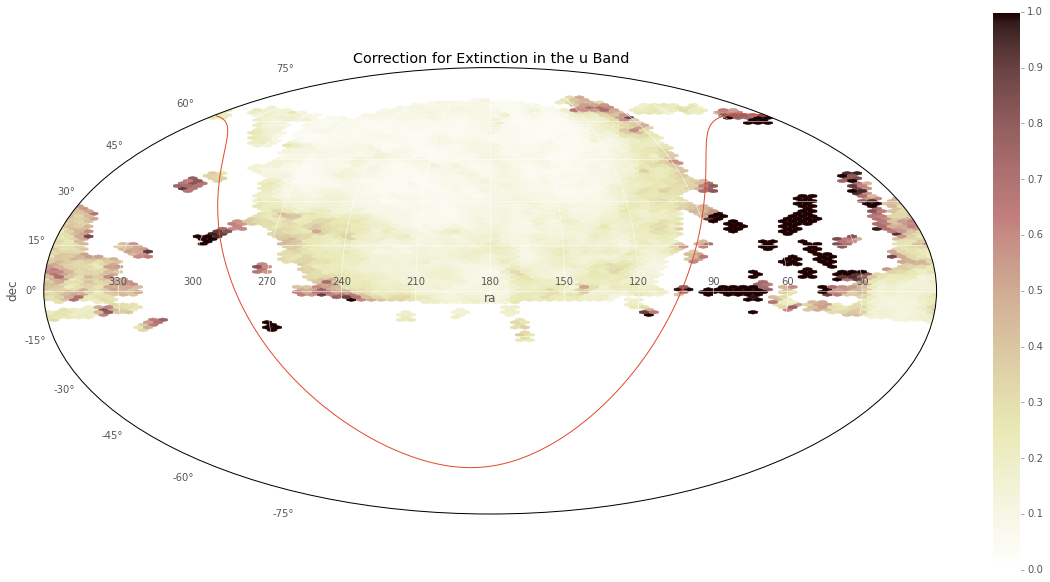

In [30]:
plot_hex_map(sdss['ra'], sdss['dec'],
             C=sdss['extinction_u'], reduce_C_function=np.mean, origin=180,
             vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r,
             title='Correction for Extinction in the u Band')

### 4.1. SFD98 Set <a id='s4.1'></a>

In [3]:
sdss['psfMag_u_sfd98'] = sdss['psfMag_u'] - sdss['extinction_u']
sdss['psfMag_g_sfd98'] = sdss['psfMag_g'] - sdss['extinction_g']
sdss['psfMag_r_sfd98'] = sdss['psfMag_r'] - sdss['extinction_r']
sdss['psfMag_i_sfd98'] = sdss['psfMag_i'] - sdss['extinction_i']
sdss['psfMag_z_sfd98'] = sdss['psfMag_z'] - sdss['extinction_z']

sdss['petroMag_u_sfd98'] = sdss['petroMag_u'] - sdss['extinction_u']
sdss['petroMag_g_sfd98'] = sdss['petroMag_g'] - sdss['extinction_g']
sdss['petroMag_r_sfd98'] = sdss['petroMag_r'] - sdss['extinction_r']
sdss['petroMag_i_sfd98'] = sdss['petroMag_i'] - sdss['extinction_i']
sdss['petroMag_z_sfd98'] = sdss['petroMag_z'] - sdss['extinction_z']

sdss['psf_u_g_sfd98'] = sdss['psfMag_u_sfd98'] - sdss['psfMag_g_sfd98']
sdss['psf_g_r_sfd98'] = sdss['psfMag_g_sfd98'] - sdss['psfMag_r_sfd98']
sdss['psf_r_i_sfd98'] = sdss['psfMag_r_sfd98'] - sdss['psfMag_i_sfd98']
sdss['psf_i_z_sfd98'] = sdss['psfMag_i_sfd98'] - sdss['psfMag_z_sfd98']

sdss['petro_u_g_sfd98'] = sdss['petroMag_u_sfd98'] - sdss['petroMag_g_sfd98']
sdss['petro_g_r_sfd98'] = sdss['petroMag_g_sfd98'] - sdss['petroMag_r_sfd98']
sdss['petro_r_i_sfd98'] = sdss['petroMag_r_sfd98'] - sdss['petroMag_i_sfd98']
sdss['petro_i_z_sfd98'] = sdss['petroMag_i_sfd98'] - sdss['petroMag_z_sfd98']

In [51]:
colour_features = ['ra', 'dec',
                   'psfMag_i_sfd98', 'petroMag_i_sfd98', 'petroRad_r',
                   'psf_u_g_sfd98', 'psf_g_r_sfd98', 'psf_r_i_sfd98', 'psf_i_z_sfd98',
                   'petroMag_r_sfd98', 'petro_u_g_sfd98', 'petro_g_r_sfd98', 'petro_r_i_sfd98', 'petro_i_z_sfd98']

_, _, y_pred_test_sfd98 = train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False)

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     843223     7396    3213
       Quasars        9045   164943   15288
       Stars          7327    20114  329952

The balanced accuracy rate is 92.75%.


In [69]:
correct_sfd98 = y_test == y_pred_test_sfd98
correct_diff_sfd98 = correct_sfd98.astype(int) - correct.astype(int)

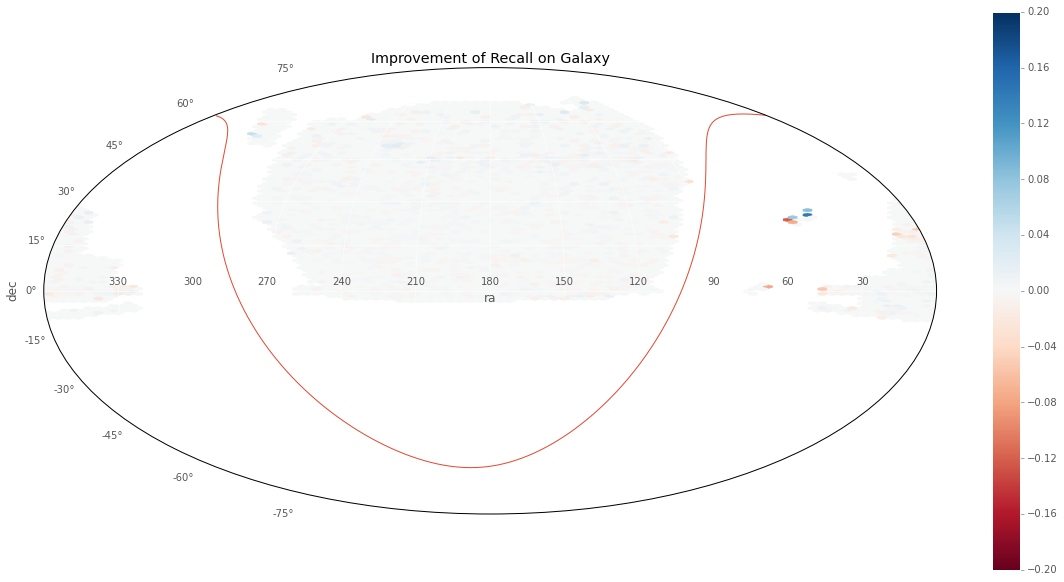

In [109]:
plot_hex_map(coords_test['ra'][is_galaxy], coords_test['dec'][is_galaxy],
             C=correct_diff_sfd98[is_galaxy], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Galaxy')

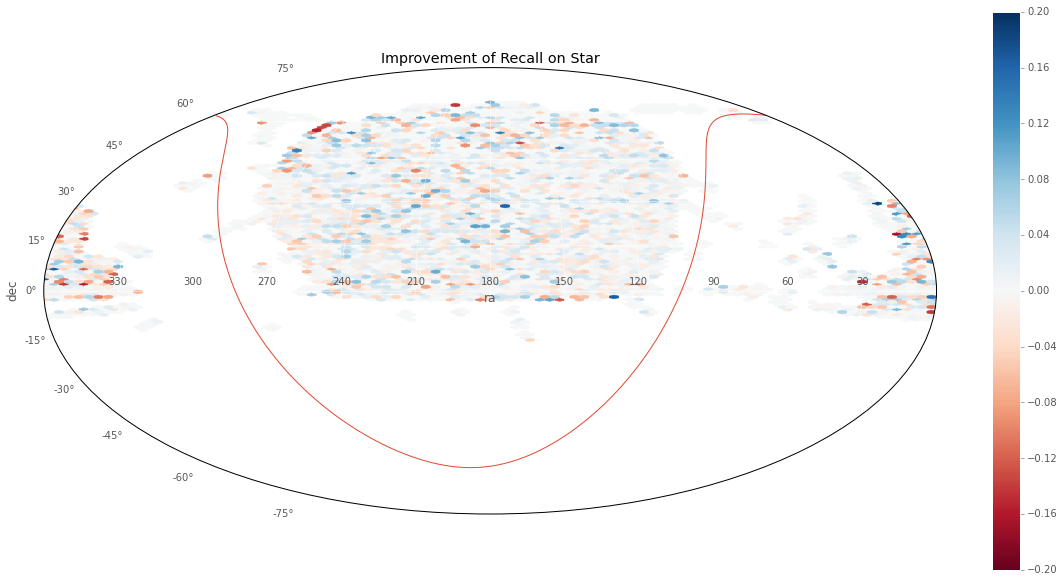

In [94]:
plot_hex_map(coords_test['ra'][is_star], coords_test['dec'][is_star],
             C=correct_diff_sfd98[is_star], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Star')

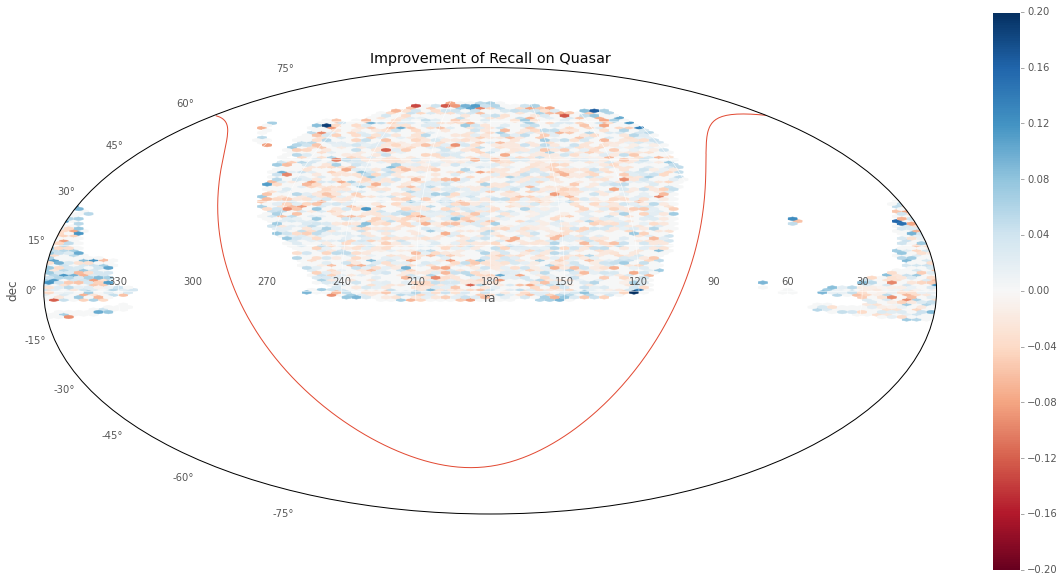

In [90]:
plot_hex_map(coords_test['ra'][is_quasar], coords_test['dec'][is_quasar],
             C=correct_diff_sfd98[is_quasar], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Quasar')

### 4.2. SF11 Set <a id='s4.2'></a>

In [53]:
sdss['E_BV'] = sdss['extinction_r'] / 2.751
sdss['A_u_sf11'] = sdss['E_BV'] * 4.239
sdss['A_g_sf11'] = sdss['E_BV'] * 3.303
sdss['A_r_sf11'] = sdss['E_BV'] * 2.285
sdss['A_i_sf11'] = sdss['E_BV'] * 1.698
sdss['A_z_sf11'] = sdss['E_BV'] * 1.263

sdss['psfMag_u_sf11'] = sdss['psfMag_u'] - sdss['A_u_sf11']
sdss['psfMag_g_sf11'] = sdss['psfMag_g'] - sdss['A_g_sf11']
sdss['psfMag_r_sf11'] = sdss['psfMag_r'] - sdss['A_r_sf11']
sdss['psfMag_i_sf11'] = sdss['psfMag_i'] - sdss['A_i_sf11']
sdss['psfMag_z_sf11'] = sdss['psfMag_z'] - sdss['A_z_sf11']

sdss['petroMag_u_sf11'] = sdss['petroMag_u'] - sdss['A_u_sf11']
sdss['petroMag_g_sf11'] = sdss['petroMag_g'] - sdss['A_g_sf11']
sdss['petroMag_r_sf11'] = sdss['petroMag_r'] - sdss['A_r_sf11']
sdss['petroMag_i_sf11'] = sdss['petroMag_i'] - sdss['A_i_sf11']
sdss['petroMag_z_sf11'] = sdss['petroMag_z'] - sdss['A_z_sf11']

sdss['psf_u_g_sf11'] = sdss['psfMag_u_sf11'] - sdss['psfMag_g_sf11']
sdss['psf_g_r_sf11'] = sdss['psfMag_g_sf11'] - sdss['psfMag_r_sf11']
sdss['psf_r_i_sf11'] = sdss['psfMag_r_sf11'] - sdss['psfMag_i_sf11']
sdss['psf_i_z_sf11'] = sdss['psfMag_i_sf11'] - sdss['psfMag_z_sf11']

sdss['petro_u_g_sf11'] = sdss['petroMag_u_sf11'] - sdss['petroMag_g_sf11']
sdss['petro_g_r_sf11'] = sdss['petroMag_g_sf11'] - sdss['petroMag_r_sf11']
sdss['petro_r_i_sf11'] = sdss['petroMag_r_sf11'] - sdss['petroMag_i_sf11']
sdss['petro_i_z_sf11'] = sdss['petroMag_i_sf11'] - sdss['petroMag_z_sf11']

In [54]:
colour_features = ['ra', 'dec',
                   'psfMag_i_sf11', 'petroMag_i_sf11', 'petroRad_r',
                   'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11',
                   'petroMag_r_sf11', 'petro_u_g_sf11', 'petro_g_r_sf11', 'petro_r_i_sf11', 'petro_i_z_sf11']

coords_test, y_test, y_pred_test_sf11 = train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False)

Here's the confusion matrix:


Predicted                 
                  Galaxies  Quasars   Stars
Actual Galaxies     843267     7367    3198
       Quasars        9064   164759   15453
       Stars          7431    20038  329924

The balanced accuracy rate is 92.72%.


In [98]:
correct_sf11 = y_test == y_pred_test_sf11
correct_diff_sf11 = correct_sf11.astype(int) - correct.astype(int)

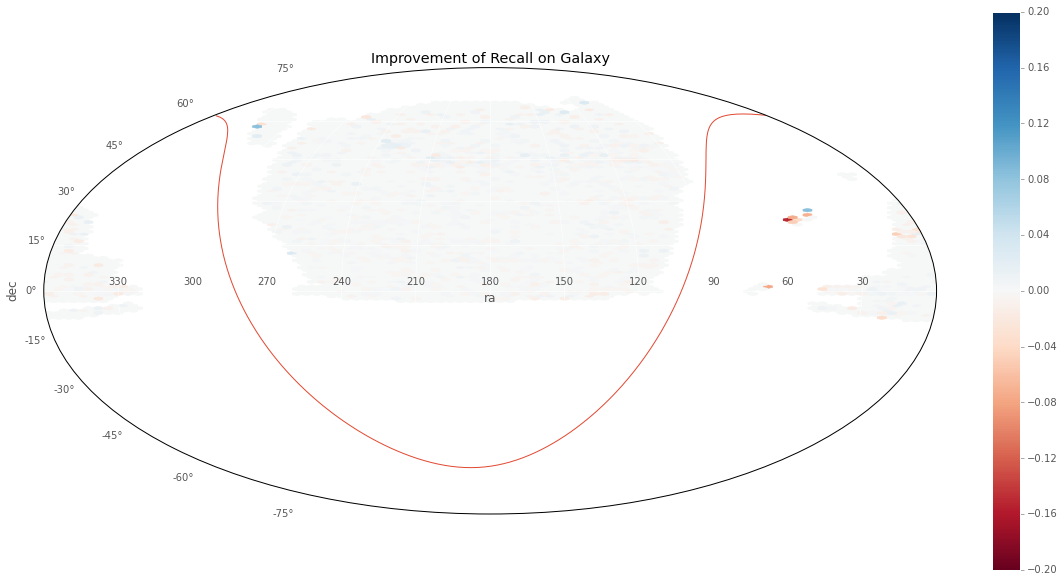

In [108]:
plot_hex_map(coords_test['ra'][is_galaxy], coords_test['dec'][is_galaxy],
             C=correct_diff_sf11[is_galaxy], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Galaxy')

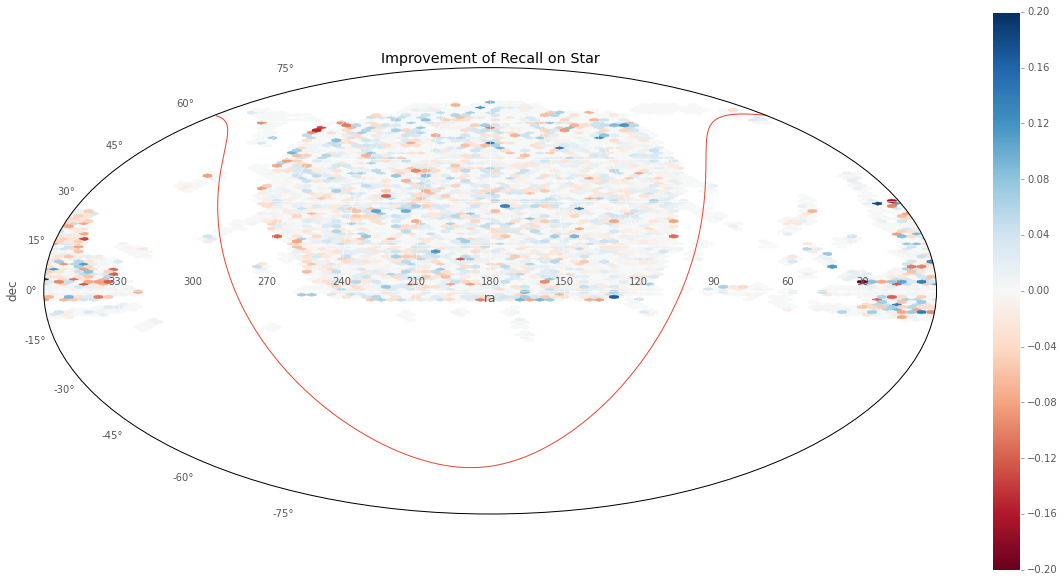

In [102]:
plot_hex_map(coords_test['ra'][is_star], coords_test['dec'][is_star],
             C=correct_diff_sf11[is_star], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Star')

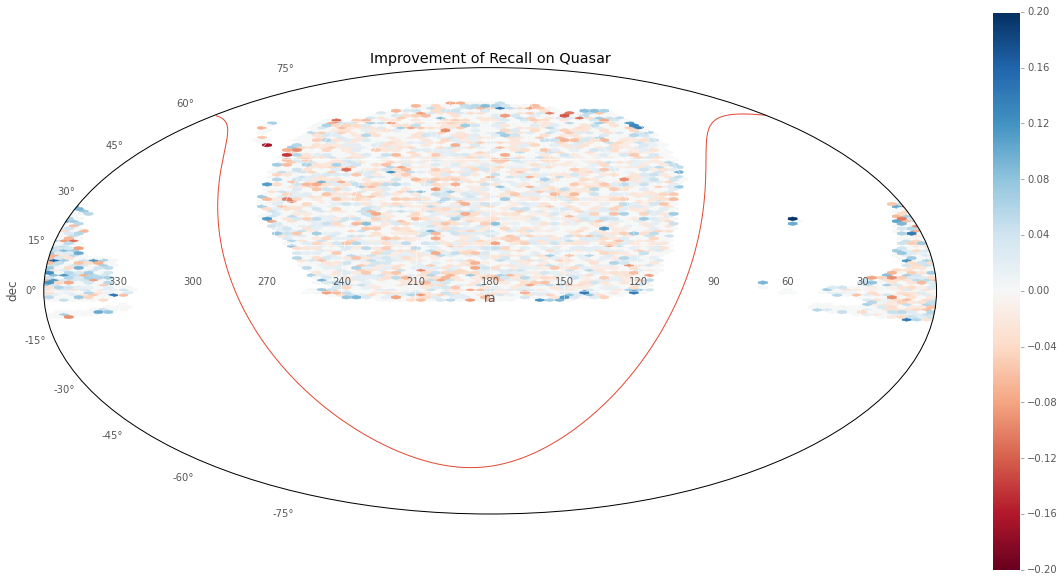

In [107]:
plot_hex_map(coords_test['ra'][is_quasar], coords_test['dec'][is_quasar],
             C=correct_diff_sf11[is_quasar], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Quasar')

### 4.3. W14 Set <a id='s4.3'></a>

In [8]:
sdss['E_BV'] = sdss['extinction_r'] / 2.751
E_region_2 = np.logical_and(sdss['E_BV'] >= 0.04, sdss['E_BV'] < 0.08)
E_region_3 = sdss['E_BV'] >= 0.08

sdss['Ecorr_BV'] = sdss['E_BV']
sdss['Ecorr_BV'].loc[E_region_2] = sdss['E_BV'][E_region_2] + 0.5 * (sdss['E_BV'][E_region_2] - 0.04)
sdss['Ecorr_BV'].loc[E_region_3] = sdss['E_BV'][E_region_3] + 0.02

sdss['A_u_w14'] = sdss['Ecorr_BV'] * 4.305
sdss['A_g_w14'] = sdss['Ecorr_BV'] * 3.288
sdss['A_r_w14'] = sdss['Ecorr_BV'] * 2.261
sdss['A_i_w14'] = sdss['Ecorr_BV'] * 1.714
sdss['A_z_w14'] = sdss['Ecorr_BV'] * 1.263

sdss['psfMag_u_w14'] = sdss['psfMag_u'] - sdss['A_u_w14']
sdss['psfMag_g_w14'] = sdss['psfMag_g'] - sdss['A_g_w14']
sdss['psfMag_r_w14'] = sdss['psfMag_r'] - sdss['A_r_w14']
sdss['psfMag_i_w14'] = sdss['psfMag_i'] - sdss['A_i_w14']
sdss['psfMag_z_w14'] = sdss['psfMag_z'] - sdss['A_z_w14']

sdss['petroMag_u_w14'] = sdss['petroMag_u'] - sdss['A_u_w14']
sdss['petroMag_g_w14'] = sdss['petroMag_g'] - sdss['A_g_w14']
sdss['petroMag_r_w14'] = sdss['petroMag_r'] - sdss['A_r_w14']
sdss['petroMag_i_w14'] = sdss['petroMag_i'] - sdss['A_i_w14']
sdss['petroMag_z_w14'] = sdss['petroMag_z'] - sdss['A_z_w14']

sdss['psf_u_g_w14'] = sdss['psfMag_u_w14'] - sdss['psfMag_g_w14']
sdss['psf_g_r_w14'] = sdss['psfMag_g_w14'] - sdss['psfMag_r_w14']
sdss['psf_r_i_w14'] = sdss['psfMag_r_w14'] - sdss['psfMag_i_w14']
sdss['psf_i_z_w14'] = sdss['psfMag_i_w14'] - sdss['psfMag_z_w14']

sdss['petro_u_g_w14'] = sdss['petroMag_u_w14'] - sdss['petroMag_g_w14']
sdss['petro_g_r_w14'] = sdss['petroMag_g_w14'] - sdss['petroMag_r_w14']
sdss['petro_r_i_w14'] = sdss['petroMag_r_w14'] - sdss['petroMag_i_w14']
sdss['petro_i_z_w14'] = sdss['petroMag_i_w14'] - sdss['petroMag_z_w14']

In [11]:
colour_features = ['ra', 'dec',
                   'psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
                   'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
                   'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14', 'petro_i_z_w14']

coords_test, y_test, y_pred_test_w14 = train_random_forest(sdss, colour_features, drop_coords=True, recall_maps=False)

Here's the confusion matrix:


Predicted                
                 Galaxies Quasars   Stars
Actual Galaxies    843258    7383    3191
       Quasars       9072  164809   15395
       Stars         7405   20091  329897

The balanced accuracy rate is 92.73%.


In [20]:
correct_w14 = y_test == y_pred_test_w14
correct_diff_w14 = correct_w14.astype(int) - correct.astype(int)

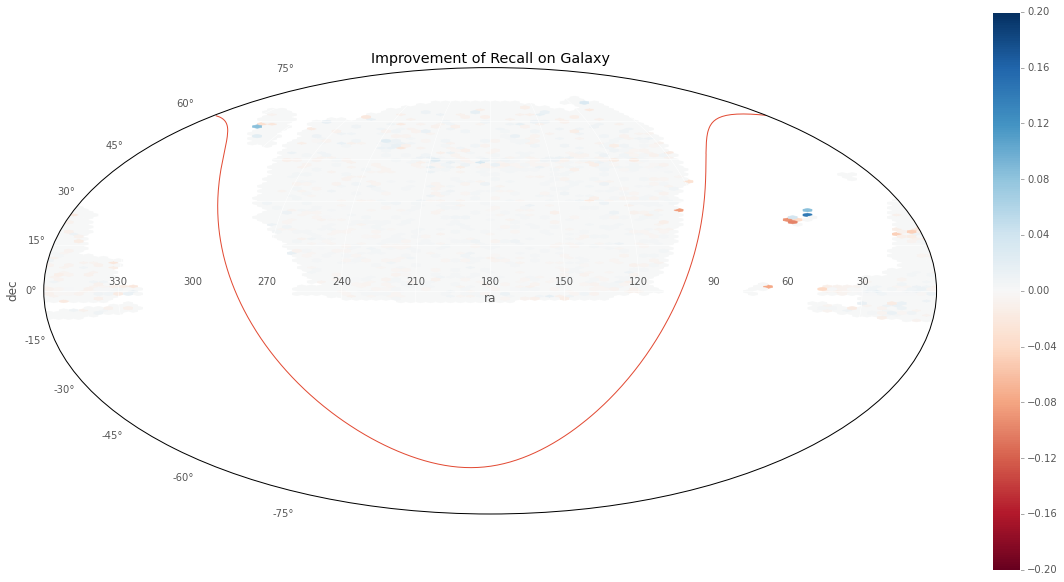

In [21]:
plot_hex_map(coords_test['ra'][is_galaxy], coords_test['dec'][is_galaxy],
             C=correct_diff_w14[is_galaxy], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Galaxy')

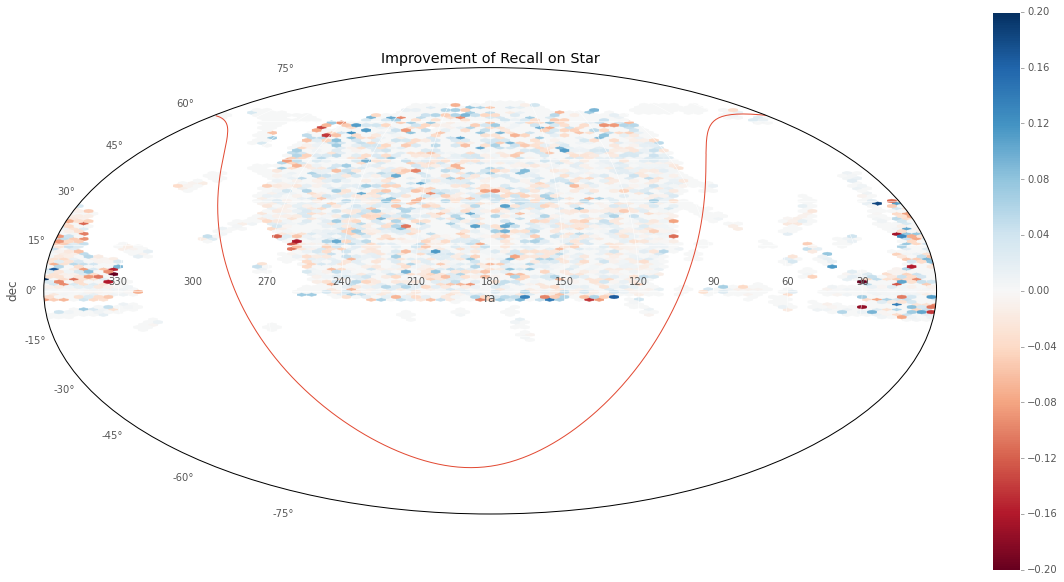

In [22]:
plot_hex_map(coords_test['ra'][is_star], coords_test['dec'][is_star],
             C=correct_diff_w14[is_star], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Star')

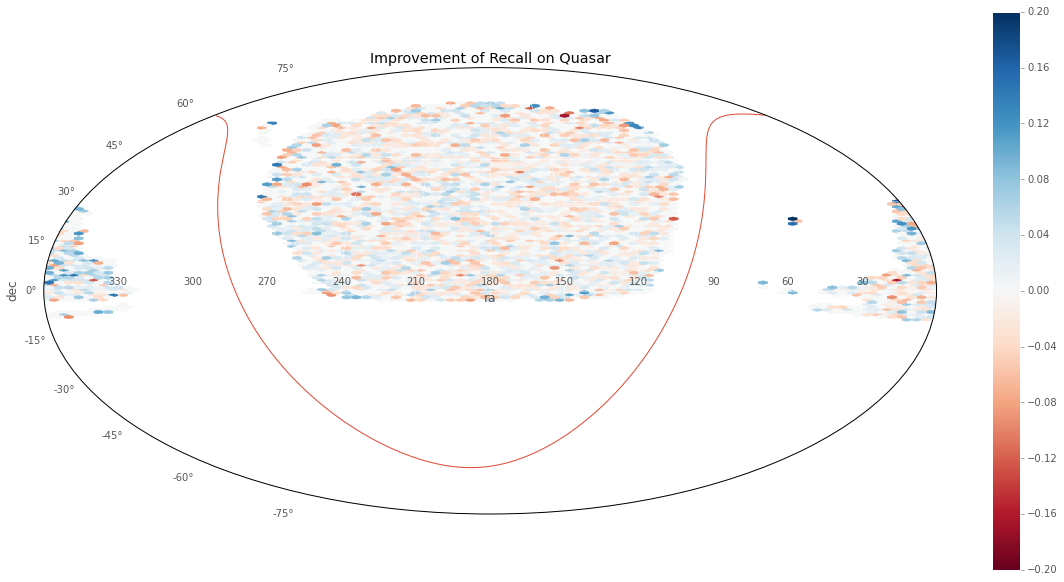

In [23]:
plot_hex_map(coords_test['ra'][is_quasar], coords_test['dec'][is_quasar],
             C=correct_diff_w14[is_quasar], reduce_C_function=C_func, origin=180,
             vmin=-0.2, vmax=0.2, mincnt=10, milky_way=True, cmap=plt.cm.RdBu,
             title='Improvement of Recall on Quasar')